In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Import Data
<p>
Import data from csv and print head of df
<p>
Data dictionary in repo.

In [20]:
df = pd.read_csv('Data\ISM647_ML1_data_encoded.csv')

df.head(10)

,target,AcctAge,DDA,DDABal,Checks,DirDep,NSF,Teller,Sav,SavBal,...,CRScore,Moved,InArea,Dep,DepAmt,Inv,InvBal,Res_R,Res_S,Res_U
0,1,0.000000,1,0.004282,0.000000,0,0,0.00,1,0.014619,...,0.589404,0,1,0.071429,0.002413,0.0,0.000266,1,0,0
1,0,0.006536,1,0.009903,0.020408,1,0,0.00,0,0.000000,...,0.516556,0,1,0.035714,0.000922,0.0,0.000266,1,0,0
2,1,0.062092,0,0.002778,0.000000,0,0,0.00,0,0.000000,...,0.403974,0,1,0.000000,0.000000,0.0,0.000266,0,1,0
3,0,0.003268,1,0.008497,0.020408,0,0,0.04,1,0.000607,...,0.509934,0,1,0.035714,0.002360,0.0,0.000266,0,1,0
4,1,0.104575,1,0.012867,0.040816,0,0,0.20,1,0.003881,...,0.430464,0,1,0.071429,0.002493,0.0,0.000266,0,1,0
5,1,0.196078,1,0.006615,0.265306,1,0,0.36,0,0.000000,...,0.476821,0,1,0.178571,0.014052,0.0,0.000266,0,0,1
6,0,0.138889,1,0.007933,0.244898,1,0,0.00,0,0.000000,...,0.466887,0,1,0.071429,0.004615,0.0,0.000266,0,0,1
7,1,0.147059,1,0.008815,0.040816,1,0,0.00,1,0.001381,...,0.519868,0,1,0.107143,0.001641,0.0,0.000266,0,0,1
8,1,0.009804,1,0.004436,0.081633,0,0,0.08,1,0.012872,...,0.493377,0,1,0.071429,0.002165,0.0,0.000266,0,1,0
9,0,0.044118,1,0.009133,0.020408,1,0,0.04,0,0.000000,...,0.311258,0,1,0.071429,0.002358,0.0,0.000266,0,0,1


## Create train, test, and validate data sets
<p>
80%, 20% split for Train and Test

In [21]:
print(len(df_encoded_norm), ':encoded data set length')

20877 :encoded data set length


In [22]:
train, test = np.split(df_encoded_norm.sample(frac=1), [int(0.8*len(df_encoded_norm))])

print(len(train), ':training examples')
print(len(test), ':test examples')

16701 :training examples
4176 :test examples


c:\Users\nlofl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Check for balance within the target features of the data set by comparing the categorical outcomes.

In [23]:
# check for imbalanced data
df_encoded_norm['target'].value_counts()

target
0    13373
1     7504
Name: count, dtype: int64

Address imbalanced training data using the SMOTE method. (Synthetic Model Oversampling Technique)

In [24]:
# address imbalance in train data using SMOTE method
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
train_smote = train.drop('target', axis=1)
train_target = train['target']
train_smote, train_target = smote.fit_resample(train_smote, train_target)

print(train_smote.shape)
print(train_target.shape)

(21410, 44)
(21410,)


## Train a Gradient Boosted Decision Tree model (XGBoost)
<p>
Train the model.

In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# initialize the random forest tree model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


In [26]:
# Set the parameter grid to tune the hyperparameters
param_grid = {
    'n_estimators': randint(100, 1000),  # Larger range to explore more complex models
    'max_depth': randint(3, 10),  # Allows for more depth to capture complexities
    'learning_rate': uniform(0.01, 0.1),  # Lower learning rates for finer learning steps
    'subsample': uniform(0.5, 0.5),  # Subsampling of the training instances
    'colsample_bytree': uniform(0.5, 0.5),  # Subsampling of columns for each tree
    'gamma': uniform(0, 0.5),  # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),  # L1 regularization term on weights (increases model sparsity)
    'reg_lambda': uniform(1, 3)  # L2 regularization term on weights
}

# tune the parameters of the model using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(train_smote, train_target)

# print the best parameters and best cross-validation accuracy
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.2f}")


Best parameters: {'colsample_bytree': 0.6707816052282725, 'gamma': 0.26863170835703504, 'learning_rate': 0.05601191589835721, 'max_depth': 9, 'n_estimators': 473, 'reg_alpha': 0.6976675736969318, 'reg_lambda': 1.5402018170478957, 'subsample': 0.8482507331135395}
Best cross-validation accuracy: 0.79


Initialize and train the model using the best parameters found above.

In [27]:
# initialize the xgboost model using the best parameters found in the previous step
xgb_best = xgb.XGBClassifier(n_estimators = random_search.best_params_['n_estimators'],
                                max_depth = random_search.best_params_['max_depth'],
                                learning_rate = random_search.best_params_['learning_rate'],
                                subsample = random_search.best_params_['subsample'],
                                colsample_bytree = random_search.best_params_['colsample_bytree'],
                                use_label_encoder=False, eval_metric='mlogloss',
                                gamma = random_search.best_params_['gamma'],
                                reg_alpha = random_search.best_params_['reg_alpha'],
                                reg_lambda = random_search.best_params_['reg_lambda'])

# fit the best parameter model to the training data
xgb_best.fit(train_smote, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6707816052282725, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.26863170835703504, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05601191589835721,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=473, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Split the target from the test data set.

In [28]:
# evaluate the model on the test set
test_target = test.pop('target')

print(test.shape, 'test shape')
print(test_target.shape, 'test target shape')

(4176, 44) test shape
(4176,) test target shape


Test the model against the training data set and determine accuracy.

In [29]:
# predict the target for the test data
test_predictions = xgb_best.predict(test)

# calculate the accuracy of the model
test_accuracy = accuracy_score(test_target, test_predictions)

print('Training accuracy:', test_accuracy)

Training accuracy: 0.742816091954023


Print relative importance of features based on model.

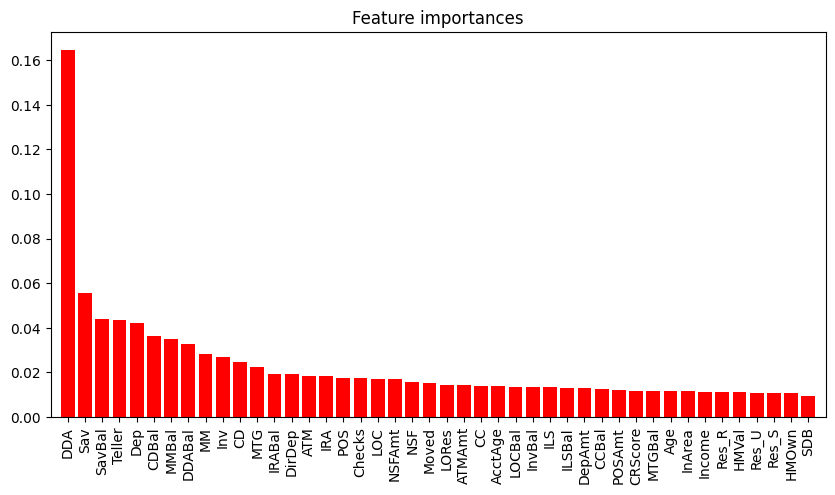

In [31]:
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(train_smote.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(train_smote.shape[1]), train_smote.columns[indices], rotation=90)
plt.xlim([-1, train_smote.shape[1]])
plt.show()


## Output Confusion Matrix and Classification Report
<p>
Metrics for performance of model predictions vs test set.

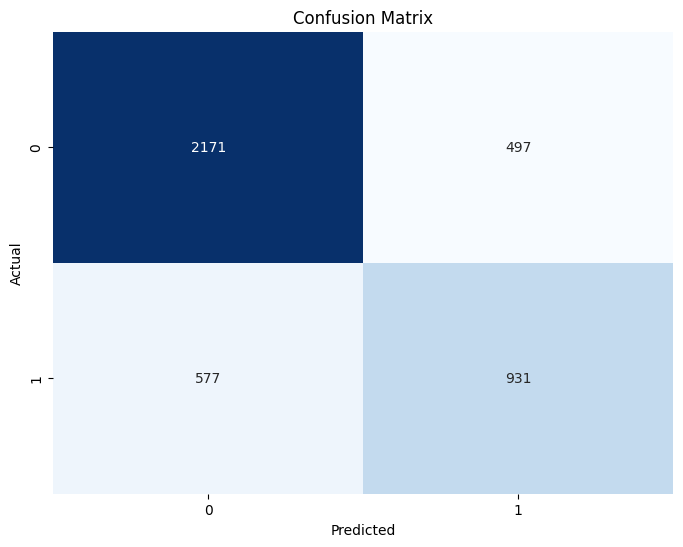

In [32]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# create confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# create a classification report
from sklearn.metrics import classification_report

print(classification_report(test_target, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2668
           1       0.65      0.62      0.63      1508

    accuracy                           0.74      4176
   macro avg       0.72      0.72      0.72      4176
weighted avg       0.74      0.74      0.74      4176

